# Trabalho Aprendizado de Máquina - Fake News

### Download do dataset

In [1]:
!git clone 'https://github.com/margato/machinelearning-fakenews'
fake_news_dataset_path = 'machinelearning-fakenews/dataset/fake_news_dataset.csv'
true_news_dataset_path = 'machinelearning-fakenews/dataset/true_news_dataset.csv'

fatal: destination path 'machinelearning-fakenews' already exists and is not an empty directory.


### Imports das bibliotecas

In [2]:
# Load data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pre processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Training
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osvaldomargato/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osvaldomargato/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osvaldomargato/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/osvaldomargato/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Pré processamento
A seguir, os dados CSV serão carregados para o Python.

Para o dataset de notícias verdadeiras, será adicionada uma coluna **is_fake** com valor 0.

Já para o dataset de notícias falsas, o valor de **is_fake** será 1.

In [3]:
fake_news = pd.read_csv(fake_news_dataset_path)
true_news = pd.read_csv(true_news_dataset_path)

In [4]:
fake_news['is_fake'] = 1
true_news['is_fake'] = 0

dataset = pd.concat([fake_news, true_news], ignore_index=True, sort=False).sample(frac=1)

dataset.shape

(44898, 5)

Não há presença de valores nulos

In [5]:
dataset.isnull().sum()

title      0
text       0
subject    0
date       0
is_fake    0
dtype: int64

É possível notar também que as notícias estão bem distribuídas, sendo 50% verdadeiras e 50% falsas.

In [6]:
dataset['is_fake'].value_counts()

1    23481
0    21417
Name: is_fake, dtype: int64

Text(0.5, 1.0, 'Distribuição dos dados')

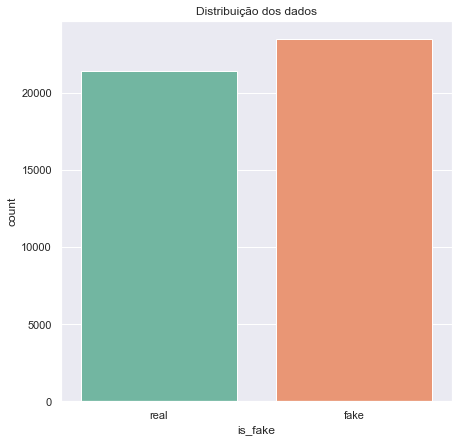

In [7]:
plt.figure(figsize=(7, 7))
sns.set(style="darkgrid")

color = sns.color_palette("Set2")
ax = sns.countplot(x="is_fake", data=dataset, palette=color)

ax.set(xticklabels=['real', 'fake'])

plt.title("Distribuição dos dados")

Text(0.5, 1.0, 'Data distribution of fake and real data')

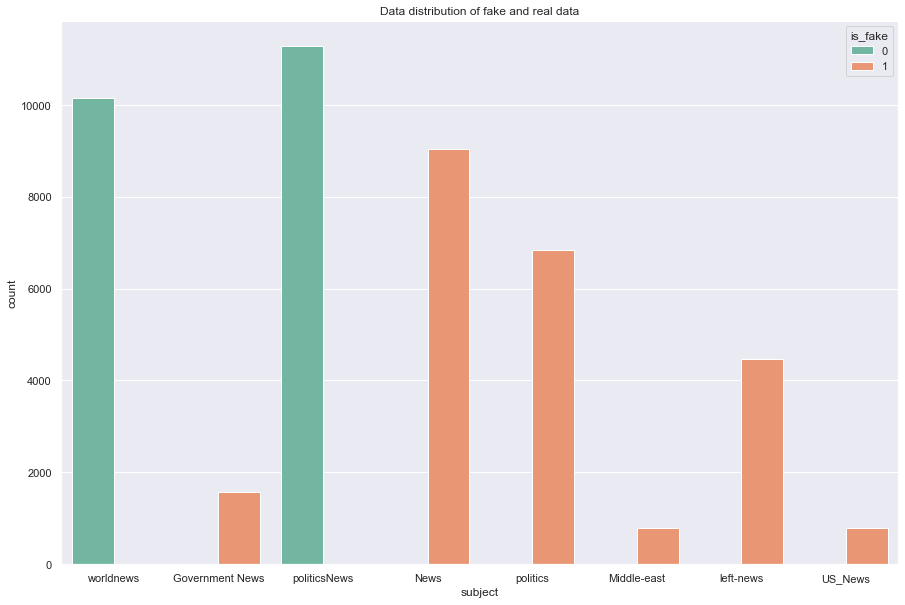

In [8]:
plt.figure(figsize=(15, 10))
sns.set(style="darkgrid")

color = sns.color_palette("Set2")
ax = sns.countplot(x="subject",  hue='is_fake', data=dataset, palette=color)

plt.title("Data distribution of fake and real data")

In [9]:
stop_words = stopwords.words("english")

In [10]:
def only_letters(text):
    _text = re.sub('[^a-zA-Z]' , ' ' , text)
    return _text

def remove_stop_words(text):
    tokens = nltk.word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

In [11]:
%%time
clean_dataset = dataset.copy()
clean_dataset['text'] = clean_dataset.text.str.lower()
clean_dataset['text'] = clean_dataset.text.str.replace(r'\b\w\b','', regex=True)

CPU times: user 1.93 s, sys: 40.3 ms, total: 1.97 s
Wall time: 1.59 s


In [12]:
%%time
clean_dataset['text'] = clean_dataset.text.apply(lambda text: only_letters(text))

CPU times: user 2.44 s, sys: 23.4 ms, total: 2.46 s
Wall time: 2.46 s


In [13]:
%%time
clean_dataset['text'] = clean_dataset.text.apply(lambda text: remove_stop_words(text))

CPU times: user 45.7 s, sys: 232 ms, total: 46 s
Wall time: 46.4 s


In [14]:
clean_dataset.head()

,title,text,subject,date,is_fake
37485,U.S. Navy halts search for three sailors lost ...,tokyo reuters navy said called search three sa...,worldnews,"November 24, 2017",0
16497,OBAMA ADMINISTRATION Sues Private Business For...,obama eeoc spiraled control meet administratio...,Government News,"Jul 15, 2016",1
24168,U.S. Republican Senate campaign wing ends fund...,washington reuters republican party senate cam...,politicsNews,"November 10, 2017",0
42928,Trump says signs new order to widen sanctions ...,new york reuters president donald trump said t...,worldnews,"September 21, 2017",0
1439,WATCH: New Documentary Explores Trump’s Russi...,past week world hit many newsworthy stories wh...,News,"May 16, 2017",1


In [15]:
%%time

from itertools import chain
from collections import Counter

list_words = clean_dataset['text'].str.split()
list_words_merge = list(chain(*list_words))

d = Counter(list_words_merge)
df = pd.DataFrame(data=d, index=['count'])
top_common_words = df.T.sort_values(by=['count'], ascending=False).reset_index().head(50)
top_common_words.head()

CPU times: user 2.33 s, sys: 318 ms, total: 2.65 s
Wall time: 2.86 s


,index,count
0,trump,134641
1,said,132825
2,president,55990
3,would,55171
4,people,41878


CPU times: user 722 ms, sys: 58.4 ms, total: 781 ms
Wall time: 326 ms


<AxesSubplot:xlabel='index', ylabel='count'>

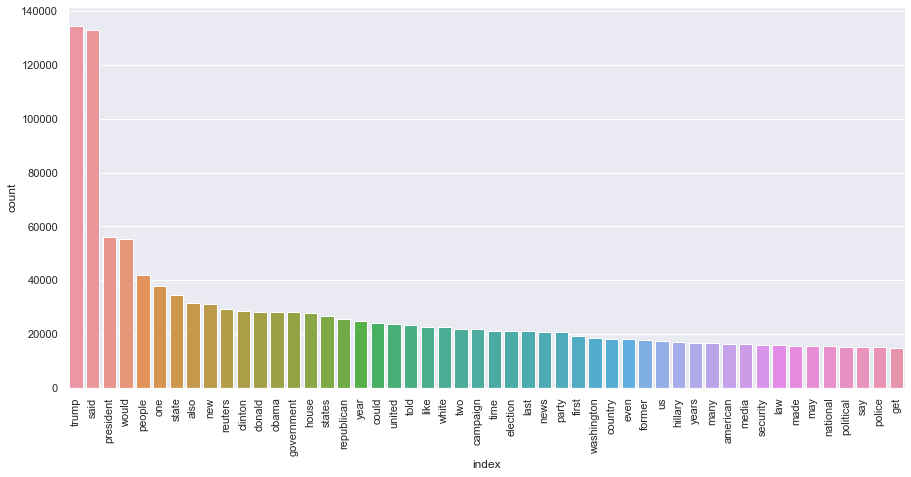

In [16]:
%%time

plt.figure(figsize=(15,7))
plt.xticks(rotation=90)
sns.set(style="darkgrid")
sns.barplot(x="index", y='count', data=top_common_words)

In [17]:
import nltk
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    pos_tag = nltk.pos_tag([word])
    tag = pos_tag[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osvaldomargato/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [18]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    tokens = nltk.word_tokenize(text)
    return' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens])

In [19]:
clean_dataset.isnull().sum()

title      0
text       0
subject    0
date       0
is_fake    0
dtype: int64

In [20]:
%%time

lemmatize_data = clean_dataset.copy()
lemmatize_data['text'] = lemmatize_data.text.apply(lambda text: word_lemmatizer(text))
lemmatize_data.head()

CPU times: user 10min 48s, sys: 46.1 s, total: 11min 34s
Wall time: 11min 41s


,title,text,subject,date,is_fake
37485,U.S. Navy halts search for three sailors lost ...,tokyo reuters navy say call search three sailo...,worldnews,"November 24, 2017",0
16497,OBAMA ADMINISTRATION Sues Private Business For...,obama eeoc spiral control meet administration ...,Government News,"Jul 15, 2016",1
24168,U.S. Republican Senate campaign wing ends fund...,washington reuters republican party senate cam...,politicsNews,"November 10, 2017",0
42928,Trump says signs new order to widen sanctions ...,new york reuters president donald trump say th...,worldnews,"September 21, 2017",0
1439,WATCH: New Documentary Explores Trump’s Russi...,past week world hit many newsworthy story whit...,News,"May 16, 2017",1


In [21]:
text = ' '.join(lemmatize_data['text']).split(" ")

CPU times: user 2.29 s, sys: 696 ms, total: 2.99 s
Wall time: 3.35 s


<AxesSubplot:xlabel='value', ylabel='key'>

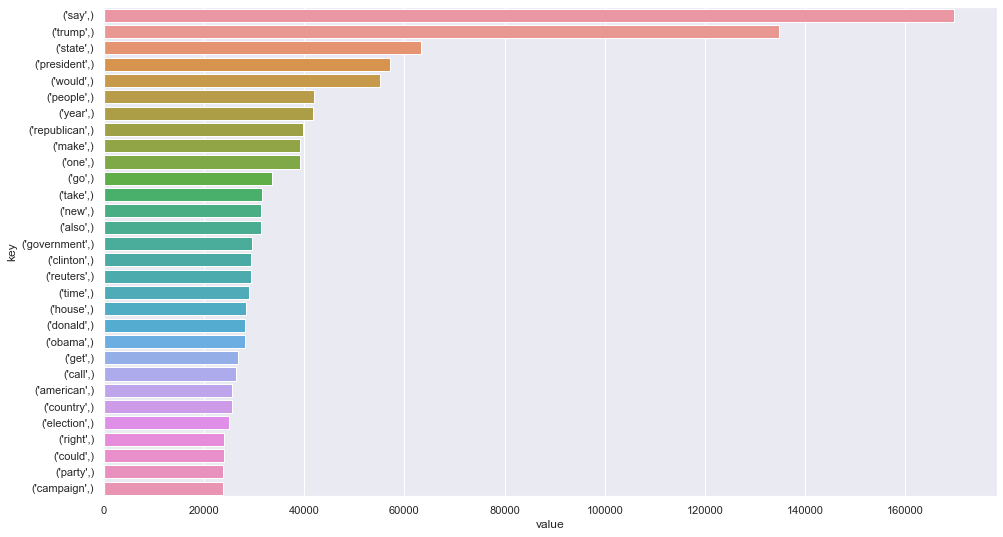

In [22]:
%%time

data_unigram = (pd.Series(nltk.ngrams(text, 1)).value_counts())[:30]

data_unigram_df = pd.DataFrame(data_unigram)
data_unigram_df = data_unigram_df.reset_index()
data_unigram_df = data_unigram_df.rename(columns={"index": "key", 0: "value"})

plt.figure(figsize = (16,9))
sns.barplot(x='value', y='key', data=data_unigram_df)

CPU times: user 7.61 s, sys: 2.69 s, total: 10.3 s
Wall time: 11.6 s


<AxesSubplot:xlabel='value', ylabel='key'>

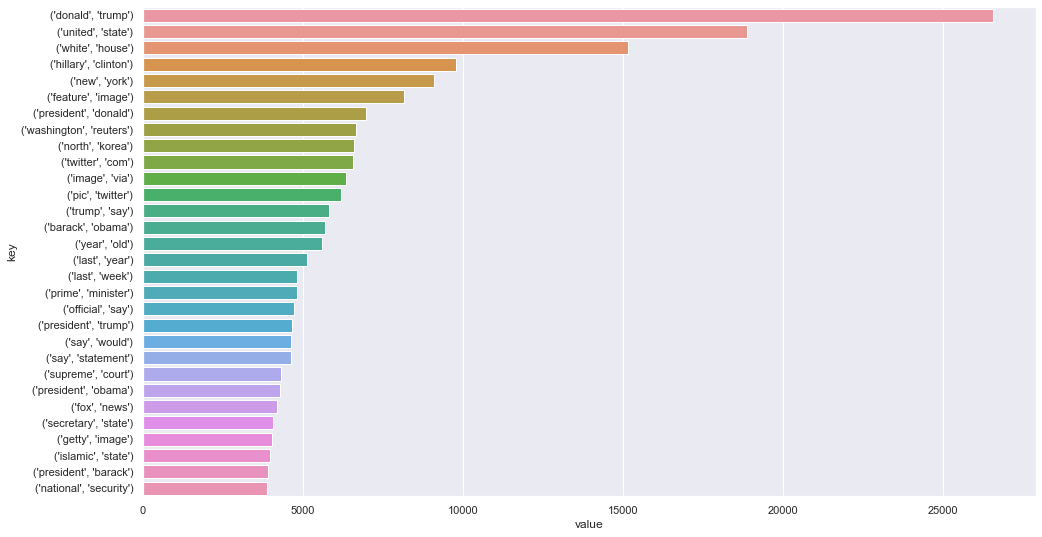

In [23]:
%%time

data_bigram = (pd.Series(nltk.ngrams(text, 2)).value_counts())[:30]

data_bigram_df = pd.DataFrame(data_bigram)
data_bigram_df = data_bigram_df.reset_index()
data_bigram_df = data_bigram_df.rename(columns={"index": "key", 0: "value"})

plt.figure(figsize = (16,9))
sns.barplot(x='value', y='key', data=data_bigram_df)

CPU times: user 19.3 s, sys: 1min 35s, total: 1min 54s
Wall time: 3min 57s


<AxesSubplot:xlabel='value', ylabel='key'>

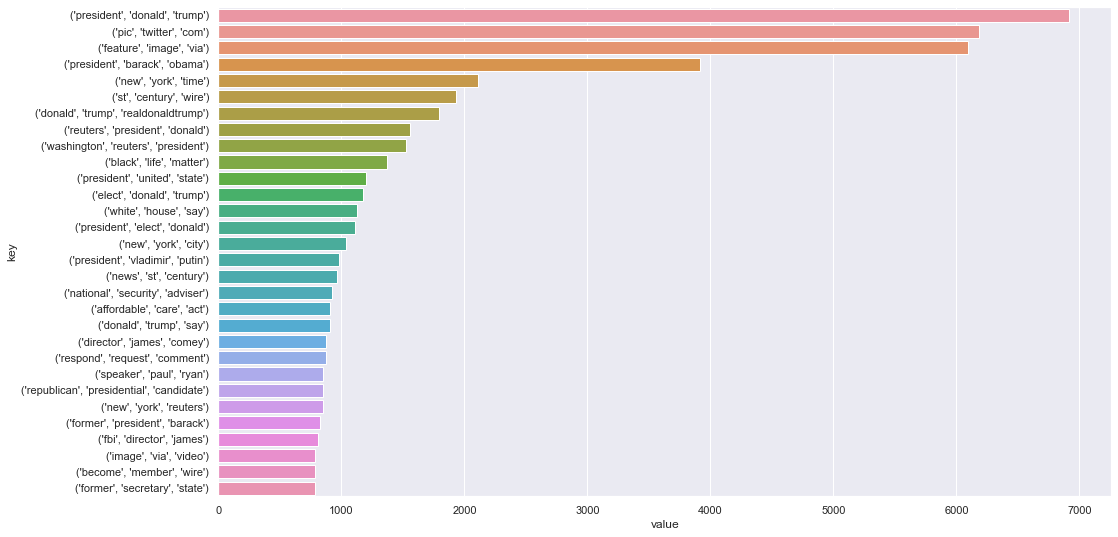

In [24]:
%%time

data_trigram = (pd.Series(nltk.ngrams(text, 3)).value_counts())[:30]

data_trigram_df = pd.DataFrame(data_trigram)
data_trigram_df = data_trigram_df.reset_index()
data_trigram_df = data_trigram_df.rename(columns={"index": "key", 0: "value"})

plt.figure(figsize = (16,9))
sns.barplot(x='value', y='key', data=data_trigram_df)

In [25]:
model_data = lemmatize_data.copy()[['text', 'is_fake']]
model_data.head()

,text,is_fake
37485,tokyo reuters navy say call search three sailo...,0
16497,obama eeoc spiral control meet administration ...,1
24168,washington reuters republican party senate cam...,0
42928,new york reuters president donald trump say th...,0
1439,past week world hit many newsworthy story whit...,1


In [26]:
dataset.isnull().sum()

title      0
text       0
subject    0
date       0
is_fake    0
dtype: int64

# Classificador

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(model_data['text'], model_data['is_fake'], random_state=0)

In [28]:
%%time 

from sklearn.feature_extraction.text import TfidfVectorizer

tfdif = TfidfVectorizer(analyzer='word', stop_words= 'english')

CPU times: user 428 µs, sys: 622 µs, total: 1.05 ms
Wall time: 4.17 ms


In [29]:
%%time

X_vec_train = tfdif.fit_transform(X_train)

CPU times: user 4.13 s, sys: 338 ms, total: 4.47 s
Wall time: 5.55 s


In [30]:
%%time

X_vec_test = tfdif.transform(X_test)

CPU times: user 1.46 s, sys: 122 ms, total: 1.58 s
Wall time: 1.92 s


In [ ]:
from sklearn.model_selection import cross_validate
import numpy as np

In [41]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_vec_train, y_train)
y_pred = classifier.predict(X_vec_test)

print(classification_report(y_test, y_pred))

scores = cross_validate(classifier, X_vec_train, y_train, cv=3, scoring=('f1_weighted', 'precision_weighted', 'recall_weighted'), return_train_score=True)
print('test_f1_weighted')
print(np.mean(scores['test_f1_weighted']), scores['test_f1_weighted'])
print()

print('test_precision_weighted')
print(np.mean(scores['test_precision_weighted']), scores['test_precision_weighted'])
print()

print('test_recall_weighted')
print(np.mean(scores['test_recall_weighted']), scores['test_recall_weighted'])

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5414
           1       0.93      0.94      0.94      5811

    accuracy                           0.93     11225
   macro avg       0.93      0.93      0.93     11225
weighted avg       0.93      0.93      0.93     11225

test_f1_weighted
0.9296525617484587 [0.92953384 0.93164958 0.92777427]

test_precision_weighted
0.9297438514338108 [0.92953575 0.9316649  0.9280309 ]

test_recall_weighted
0.9296765997774417 [0.92953229 0.93166429 0.92783321]


In [40]:
from sklearn.linear_model import PassiveAggressiveClassifier


passive_agressive_classifier = PassiveAggressiveClassifier(C = 0.5)
passive_agressive_classifier.fit(X_vec_train, y_train)
y_pred = passive_agressive_classifier.predict(X_vec_test)

print(classification_report(y_test, y_pred))

scores = cross_validate(passive_agressive_classifier, X_vec_train, y_train, cv=3, scoring=('f1_weighted', 'precision_weighted', 'recall_weighted'), return_train_score=True)
print('test_f1_weighted')
print(np.mean(scores['test_f1_weighted']), scores['test_f1_weighted'])
print()

print('test_precision_weighted')
print(np.mean(scores['test_precision_weighted']), scores['test_precision_weighted'])
print()

print('test_recall_weighted')
print(np.mean(scores['test_recall_weighted']), scores['test_recall_weighted'])

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5414
           1       0.99      0.99      0.99      5811

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

test_f1_weighted
0.9915662054364273 [0.99055712 0.99251597 0.99162552]

test_precision_weighted
0.9915675524348028 [0.99055846 0.99251597 0.99162823]

test_recall_weighted
0.9915659730104278 [0.99055679 0.99251604 0.99162509]
